In [26]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA, DictionaryLearning, IncrementalPCA, KernelPCA
from matplotlib import cm
from sklearn.metrics import rand_score, silhouette_score, fowlkes_mallows_score, calinski_harabasz_score, \
    homogeneity_score, mutual_info_score, davies_bouldin_score, v_measure_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, FunctionTransformer, minmax_scale
from concurrent.futures import ThreadPoolExecutor
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.feature_selection import f_classif,mutual_info_classif,chi2
import yellowbrick.features.pca

from sklearn.preprocessing import LabelEncoder
import yellowbrick.cluster

In [27]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [28]:
save_prefix="analysis/images/"

In [29]:
df1 = pd.read_csv("data/Australian_Rain/balanced_australian_rain.csv",low_memory=False)

y = df1['RainTomorrow'].astype(str)
X = df1.drop(['RainTomorrow'],axis=1)
_y_unique_labels = y.unique().shape[0]
y=LabelEncoder().fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y)

In [30]:
internal_scoring_algos = {
    "si":silhouette_score,  #  measure of how tight each individual clusters are, and how close they are to neighbors -1 to 1 (best)
    "ch":calinski_harabasz_score,  #  Ratio of cluster tightness to cluster dispersion.  higher ratio is tighter, more dispersed clusters
    "db":davies_bouldin_score  # Determines how similar a cluster is to its closest cluster neighbors
}
external_scoring_algos = {
    "fm":fowlkes_mallows_score,
    "hs":homogeneity_score,  # measure of how consistently samples of a given ground truth are placed into the correct cluster
    "mi":mutual_info_score,  # Determines the similarity between clusters by examining samples within different clusters and their similarity
    "rs":rand_score,  #  Measures similarity between two clusterings by considering all pairs and determining what has been assigned to same, or different, clusters
    "vs":v_measure_score, #  Measures cluster labeling to truthful labeling, irregardless of permutations of labels
}
all_scores={}

## Visualize KMeans

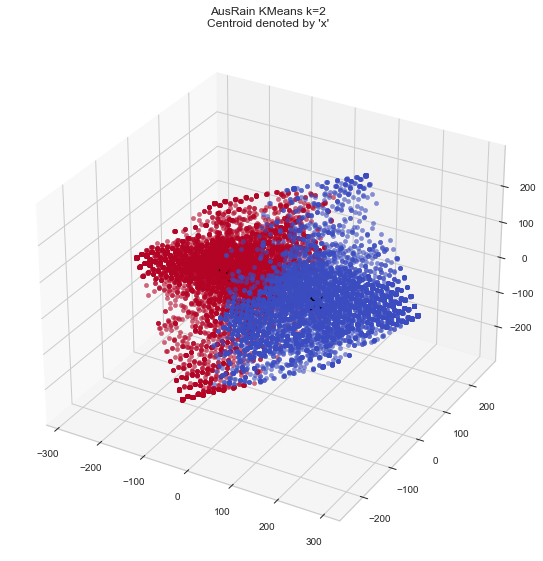

{
    "internal_scores": {
        "si": 0.3216738188803344,
        "ch": 10128.759086470212,
        "db": 1.1924525777838666
    },
    "external_scores": {
        "fm": 0.5070733541833902,
        "hs": 0.010175092114507072,
        "mi": 0.007052811353125521,
        "rs": 0.5070106113499632,
        "vs": 0.01017640797170189
    }
}


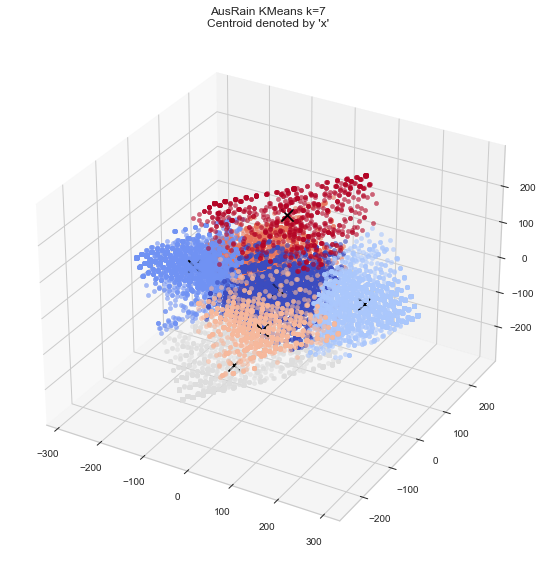

{
    "internal_scores": {
        "si": 0.325185586437166,
        "ch": 7822.969628545392,
        "db": 1.0430656880954443
    },
    "external_scores": {
        "fm": 0.3078760102063973,
        "hs": 0.010406453445486425,
        "mi": 0.0072131782376158304,
        "rs": 0.5023154040569526,
        "vs": 0.005797946345735141
    }
}


In [31]:
optimals=(2,7) # from AusRainAnalysis.ipynb..

for k in optimals:
    title=f"AusRain KMeans k={k}\nCentroid denoted by 'x'"
    model = KMeans(n_clusters=k,n_init=3,copy_x=True,algorithm='auto').fit(X_train)
    pred=model.predict(X_test)
    color_map = cm.get_cmap('coolwarm', k)
    pca = PCA(3).fit(X_test)
    x_points = pca.transform(X_test)
    centroids = pca.transform(model.cluster_centers_)
    fig = plt.figure(figsize=(12.8,9.6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    for (x, y, z), label in zip(x_points, pred):
        color = color_map(label)
        ax.scatter(x,y,z,color=color,alpha=.6)
    for i in range(len(centroids)):
        color='black'
        x,y,z=centroids[i]
        marker = 'x'
        ax.scatter(x,y,z,
                   color=color,
                   marker=marker,
                   alpha=1.0,
                   s=170-(len(centroids)**1.5))
    title=title.replace(' ','_').replace('\n','_')
    savepath=f"{save_prefix}{title}.png"
    plt.savefig(savepath)
    plt.show()
    internal_scores = {name:f(X_test,pred) for name,f in internal_scoring_algos.items()}
    external_scores = {name:f(y_test,pred) for name,f in external_scoring_algos.items()}
    scores={
        "internal_scores":internal_scores,
        "external_scores":external_scores
    }
    print(json.dumps(scores,indent=4))
    all_scores[title]=scores

## Visualize EMax

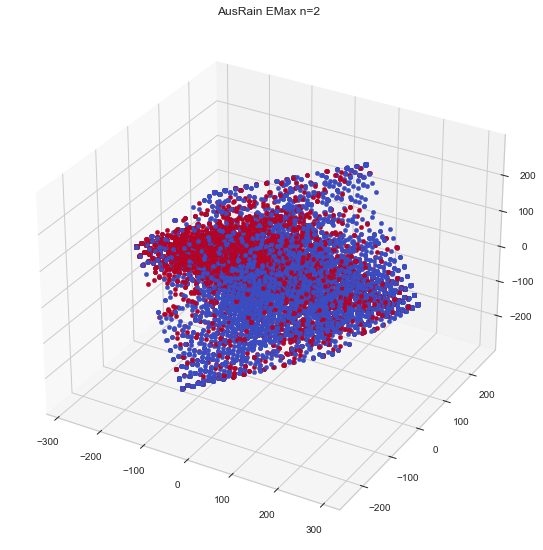

{
    "internal_scores": {
        "si": 0.10956578697681303,
        "ch": 2259.3959352275665,
        "db": 2.4957729752729434
    },
    "external_scores": {
        "fm": 0.541775280925655,
        "hs": 0.06025858173431594,
        "mi": 0.041767917636155394,
        "rs": 0.541053093875039,
        "vs": 0.060329398227832155
    }
}


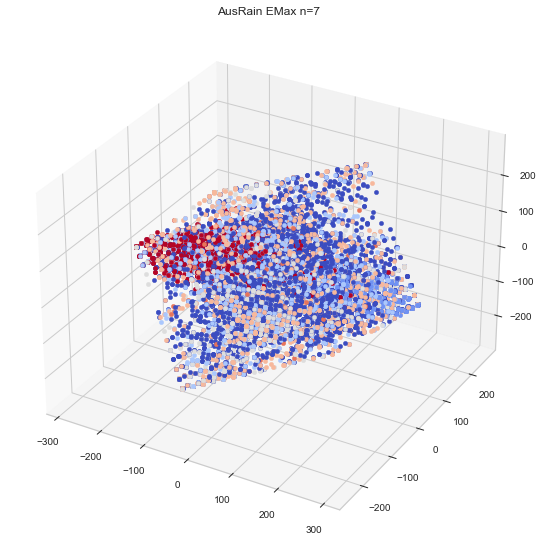

{
    "internal_scores": {
        "si": -0.16508355479676215,
        "ch": 370.3858058017817,
        "db": 8.921709471090198
    },
    "external_scores": {
        "fm": 0.4490486964319608,
        "hs": 0.1537780127086334,
        "mi": 0.10659041723526172,
        "rs": 0.5503806248615495,
        "vs": 0.096506424093544
    }
}


In [32]:
optimals=(2,7) # from AusRainAnalysis.ipynb..
scores = {}
for k in optimals:
    title=f"AusRain EMax n={k}"
    model = GaussianMixture(n_components=k, covariance_type='full', max_iter=50, n_init=3,tol=1e-1).fit(X_train)
    pred=model.predict(X_test)
    color_map = cm.get_cmap('coolwarm', k)
    pca = PCA(3).fit(X_test)
    x_points = pca.transform(X_test)
    fig = plt.figure(figsize=(12.8,9.6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    for (x, y, z), label in zip(x_points, pred):
        color = color_map(label)
        ax.scatter(x,y,z,color=color,alpha=1.0)
    savepath=f"{save_prefix}{title.replace(' ','_')}.png"
    plt.savefig(savepath)
    plt.show()
    internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
    external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
    scores={
        "internal_scores":internal_scores,
        "external_scores":external_scores
    }
    print(json.dumps(scores,indent=4))
    all_scores[title]=scores

## Visualize R-Proj

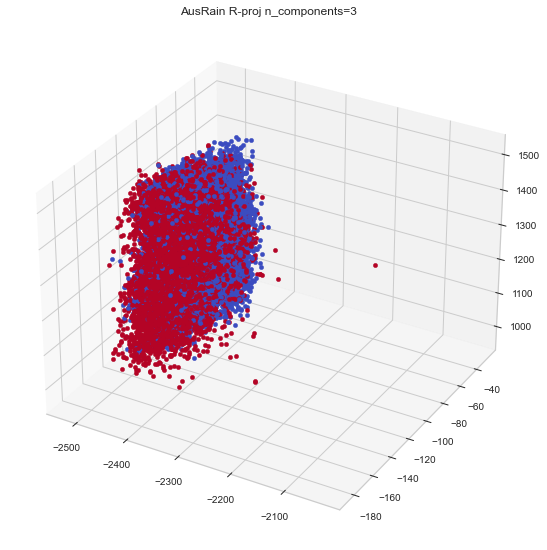

{
    "internal_scores": {
        "si": -0.16508355479676215,
        "ch": 370.3858058017817,
        "db": 8.921709471090198
    },
    "external_scores": {
        "fm": 0.4490486964319608,
        "hs": 0.1537780127086334,
        "mi": 0.10659041723526172,
        "rs": 0.5503806248615495,
        "vs": 0.096506424093544
    }
}


In [33]:
model=SparseRandomProjection(n_components=3,
                             density='auto',
                             dense_output=True).fit(X_train)

title=f"AusRain R-proj n_components=3"
x,z,y=np.split(model.transform(X_test),3,axis=1)
color_map = cm.get_cmap('coolwarm',_y_unique_labels)
fig = plt.figure(figsize=(12.8,9.6))
ax = fig.add_subplot(projection='3d')
ax.set_title(title)
for x, y, z,label in zip(x,y,z,y_test):
    color = color_map(label)
    ax.scatter(x,y,z,color=color,alpha=1.0)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))

## KPCA

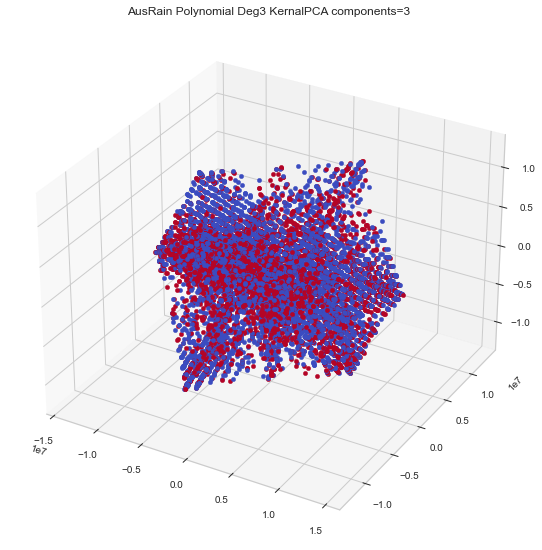

In [53]:
kpca=KernelPCA(3,kernel='poly',degree=3).fit(X_train)
pca_x = kpca.transform(X_train)
title=f"AusRain Polynomial Deg3 KernalPCA components=3"
x,z,y=np.split(kpca.transform(X_test),3,axis=1)
color_map = cm.get_cmap('coolwarm',_y_unique_labels)
fig = plt.figure(figsize=(12.8,9.6))
ax = fig.add_subplot(projection='3d')
ax.set_title(title)
for x, y, z,label in zip(x,y,z,y_test):
    color = color_map(label)
    ax.scatter(x,y,z,color=color,alpha=1.0)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()

## PCA+KMeans

In [35]:
title=f"AusRain PCA 91% + KMeans"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",PCA(0.91)),
    ("cluster",KMeans(n_clusters=7,n_init=3,copy_x=True,algorithm='auto')) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": -0.05855791385544366,
        "ch": 698.1128520406459,
        "db": 6.881050255517057
    },
    "external_scores": {
        "fm": 0.3345567625924688,
        "hs": 0.15088568200114727,
        "mi": 0.10458561348300204,
        "rs": 0.5271345419774032,
        "vs": 0.08158977599715943
    }
}


##  ICA+KMeans

In [36]:
title=f"AusRain ICA 8 + KMeans"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",FastICA(8)),
    ("cluster",KMeans(n_clusters=7,n_init=3,copy_x=True,algorithm='auto')) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": 0.020844991625468764,
        "ch": 1598.6311476384096,
        "db": 4.308213408153294
    },
    "external_scores": {
        "fm": 0.34498242591628214,
        "hs": 0.16188827427076324,
        "mi": 0.11221200219768719,
        "rs": 0.532074029612275,
        "vs": 0.08864275699953834
    }
}


##  R-Proj+Kmeans

In [37]:
title=f"AusRain RProj 9 + KMeans"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",SparseRandomProjection(9)),
    ("cluster",KMeans(n_clusters=7,n_init=3,copy_x=True,algorithm='auto')) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": -0.031684774671275756,
        "ch": 1258.091561065065,
        "db": 4.740790383079507
    },
    "external_scores": {
        "fm": 0.3627215034231052,
        "hs": 0.18738174110125702,
        "mi": 0.12988266407172427,
        "rs": 0.541442008438825,
        "vs": 0.10305389902981546
    }
}


## KPCA+KMeans

In [38]:
title=f"AusRain KernelPCA 3 + KMeans"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",KernelPCA(3,kernel='linear')),
    ("cluster",KMeans(n_clusters=7,n_init=3,copy_x=True,algorithm='auto')) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": -0.07453599187620227,
        "ch": 750.1860858191881,
        "db": 5.55197423603032
    },
    "external_scores": {
        "fm": 0.33250725217534693,
        "hs": 0.16242203795290877,
        "mi": 0.11258197767456321,
        "rs": 0.5296592061246411,
        "vs": 0.0867362130237207
    }
}


##  PCA+EMax

In [39]:
title=f"AusRain PCA 91% + EMax"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",PCA(0.91)),
    ("cluster", GaussianMixture(n_components=7, covariance_type='full', max_iter=50, n_init=3,tol=1e-1)) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": -0.13704103708192994,
        "ch": 230.83138487747772,
        "db": 8.9212581838003
    },
    "external_scores": {
        "fm": 0.4354726712684343,
        "hs": 0.22212366049650842,
        "mi": 0.1539638419895982,
        "rs": 0.5641825678060919,
        "vs": 0.1305484359867848
    }
}


## Visualize ICA+EMax

In [40]:
title=f"AusRain ICA 8 + EMax"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",FastICA(8)),
    ("cluster", GaussianMixture(n_components=7, covariance_type='full', max_iter=50, n_init=3,tol=1e-1)) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": -0.04508518963578753,
        "ch": 1066.9159308136755,
        "db": 5.873392790685155
    },
    "external_scores": {
        "fm": 0.34604284293599147,
        "hs": 0.18425104105661727,
        "mi": 0.1277126358725117,
        "rs": 0.5334171504981807,
        "vs": 0.09982083172364986
    }
}


## Visualize R-Proj+EMax

In [41]:
title=f"AusRain RProj 9 + EMax"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",SparseRandomProjection(9)),
    ("cluster", GaussianMixture(n_components=7, covariance_type='full', max_iter=50, n_init=3,tol=1e-1)) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": -0.06709472095545553,
        "ch": 362.97637894868495,
        "db": 7.597209409877583
    },
    "external_scores": {
        "fm": 0.381528136269723,
        "hs": 0.21311185918941616,
        "mi": 0.14771735951499204,
        "rs": 0.5460354905475827,
        "vs": 0.11858877504914697
    }
}


## Visualize KPCA+EMax

In [42]:
title=f"AusRain linear KPCA 3 + EMax"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",KernelPCA(3,kernel='linear')),
    ("cluster", GaussianMixture(n_components=7, covariance_type='full', max_iter=50, n_init=3,tol=1e-1)) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": -0.06691596389471172,
        "ch": 753.9070319351495,
        "db": 6.091104051607914
    },
    "external_scores": {
        "fm": 0.34509696231474923,
        "hs": 0.1698495925534688,
        "mi": 0.1177303479127158,
        "rs": 0.5340155388878358,
        "vs": 0.09139530701404251
    }
}


## Train PCA+NN

In [43]:
title=f"AusRain Train NN with PCA 91%"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",PCA(0.91,whiten=False)),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=1500)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=score

0.8577363000056906


## Train ICA+NN

In [44]:
title=f"AusRain Train NN with ICA 8"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",FastICA(8)),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=1500)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=score

0.8441927957662323


## Train R-Proj+NN

In [45]:
title=f"AusRain Train NN with RProj 9"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",SparseRandomProjection(9)),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=1500)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=score

0.8448187560462073


## Train KPCA+NN

In [46]:
title=f"AusRain Train NN with linear KPCA 3"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",KernelPCA(3,kernel='linear')),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=1500)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=score

0.76224890456951


## Train KMeans+NN

In [47]:
title=f"AusRain Train NN with linear KMeans 7"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("cluster",KMeans(n_clusters=7,n_init=3,copy_x=True,algorithm='auto')),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=100)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=score


0.8252432709269902


## Train EMax+NN

In [48]:
class GMMWrapper(GaussianMixture):
    def __init__(self,n_components=1, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10):
        super().__init__(n_components=n_components, covariance_type=covariance_type, tol=tol, reg_covar=reg_covar, max_iter=max_iter, n_init=n_init, init_params=init_params, weights_init=weights_init, means_init=means_init, precisions_init=precisions_init, random_state=random_state, warm_start=warm_start, verbose=verbose, verbose_interval=verbose_interval)
    def transform(self,*args,**kwargs):
        """
            So... what i want is a representation of how likely a given sample is going to be so come from any specifc n_cluster gaussians
            there is not transform method for this, because its not really a model.
            So what im doing instead, is getting the output of get_proba, which outputs basically what we would expect for a transform..
            for each sample it gives you an array of n_cluster length where each element in the array is the liklihood that the sample is part of that gaussian
        """
        return self.predict_proba(*args,**kwargs)

In [49]:
title=f"AusRain Train NN with linear EMax 7"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("cluster",GMMWrapper(7,covariance_type='full', max_iter=1, n_init=3,tol=1e-1)),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=1500)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=score

0.7478518181300859


In [50]:
print(json.dumps(all_scores,indent=4))

{
    "AusRain_KMeans_k=2_Centroid_denoted_by_'x'": {
        "internal_scores": {
            "si": 0.3216738188803344,
            "ch": 10128.759086470212,
            "db": 1.1924525777838666
        },
        "external_scores": {
            "fm": 0.5070733541833902,
            "hs": 0.010175092114507072,
            "mi": 0.007052811353125521,
            "rs": 0.5070106113499632,
            "vs": 0.01017640797170189
        }
    },
    "AusRain_KMeans_k=7_Centroid_denoted_by_'x'": {
        "internal_scores": {
            "si": 0.325185586437166,
            "ch": 7822.969628545392,
            "db": 1.0430656880954443
        },
        "external_scores": {
            "fm": 0.3078760102063973,
            "hs": 0.010406453445486425,
            "mi": 0.0072131782376158304,
            "rs": 0.5023154040569526,
            "vs": 0.005797946345735141
        }
    },
    "AusRain EMax n=2": {
        "internal_scores": {
            "si": 0.10956578697681303,
            "c

In [51]:
import json
json.dump(all_scores,open("analysis/AusRain-scores.json","w"),indent=4)